# Sowing Success: How Machine Learning Helps Farmers Select the Best Crops

![Farmer in a field](farmer_in_a_field.jpg)

Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. However, it can be an expensive and time-consuming process, which can cause farmers to prioritize which metrics to measure based on their budget constraints.

Farmers have various options when it comes to deciding which crop to plant each season. Their primary objective is to maximize the yield of their crops, taking into account different factors. One crucial factor that affects crop growth is the condition of the soil in the field, which can be assessed by measuring basic elements such as nitrogen and potassium levels. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.

A farmer reached out to you as a machine learning expert for assistance in selecting the best crop for his field. They've provided you with a dataset called `soil_measures.csv`, which contains:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"pH"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

Each row in this dataset represents various measures of the soil in a particular field. Based on these measurements, the crop specified in the `"crop"` column is the optimal choice for that field.  

In this project, you will apply machine learning to build a multi-class classification model to predict the type of `"crop"`, while using techniques to avoid multicollinearity, which is a concept where two or more features are highly correlated.

In [17]:
# All required libraries are imported here for you.
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import f1_score

# Load the dataset
crops = pd.read_csv("soil_measures.csv")
crops.head()

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


In [18]:
# exploratory data analysis
crops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       2200 non-null   int64  
 1   P       2200 non-null   int64  
 2   K       2200 non-null   int64  
 3   ph      2200 non-null   float64
 4   crop    2200 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 86.1+ KB


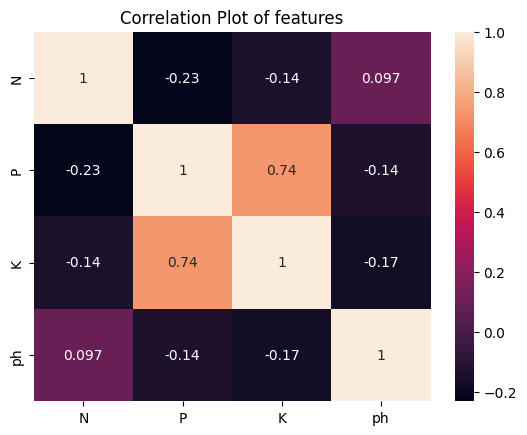

In [19]:
# exploring the correlation between features

data = crops.drop('crop', axis=1).values.T
names = crops.drop('crop', axis=1).columns
corr = np.corrcoef(data)
sns.heatmap(corr, annot=True)
pos, lab = plt.xticks()
plt.xticks(pos, names)
plt.yticks(pos, names)
plt.title('Correlation Plot of features')
plt.show()

In [20]:
# statistics of dataset
crops.describe()

,N,P,K,ph
count,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,6.469480
std,36.917334,32.985883,50.647931,0.773938
min,0.000000,5.000000,5.000000,3.504752
25%,21.000000,28.000000,20.000000,5.971693
50%,37.000000,51.000000,32.000000,6.425045
75%,84.250000,68.000000,49.000000,6.923643
max,140.000000,145.000000,205.000000,9.935091


In [21]:
# checking if there are any missing values
crops.isna().sum().sort_values()

N       0
P       0
K       0
ph      0
crop    0
dtype: int64

In [22]:
# converting categorical tagets to numerical 
map_cats = {'rice':1, 'maize':2, 'chickpea':3, 'kidneybeans':4, 'pigeonpeas':5, 'mothbeans':6, 'mungbean':7,
            'blackgram':8, 'lentil':9, 'pomegranate':10, 'banana':11, 'mango':12, 'grapes':13, 'watermelon':14,
            'muskmelon':15, 'apple':16, 'orange':17, 'papaya':18, 'coconut':19, 'cotton':20, 'jute':21,
            'coffee':22}
crops['crop'] = crops['crop'].map(map_cats)

In [23]:
crops.head()

,N,P,K,ph,crop
0,90,42,43,6.502985,1
1,85,58,41,7.038096,1
2,60,55,44,7.840207,1
3,74,35,40,6.980401,1
4,78,42,42,7.628473,1


In [24]:
# splitting data for feature selection
X = crops.drop('crop', axis=1).values
y = crops[['crop']].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

# feature selection
cols = crops.drop('crop', axis=1).columns
results = []
for feature in range(crops.shape[1]-1):
    mdl = LogisticRegression(max_iter=2000, multi_class='multinomial')
    mdl.fit(Xtrain[:,feature].reshape(-1,1), ytrain)
    ypred = mdl.predict(Xtest[:,feature].reshape(-1,1))
    f1_per_feature = f1_score(ytest, ypred, average='weighted')
    results.append((cols[feature], f1_per_feature))

results

[('N', 0.11394971482141839),
 ('P', 0.19695757969483496),
 ('K', 0.2759190651197788),
 ('ph', 0.06585894898691975)]

After analyzing the correlation plot, a **strong positive correlation between 'P' and 'K' is evident**. Consequently, including both features in our model raises concerns about multicollinearity. To mitigate this, we need to eliminate one of these columns.

In our investigation of individual feature performance concerning the target feature, it becomes apparent that **'K' outperforms 'P' based on their respective f1 scores**. Hence, to enhance the model's predictive capability, **we opt to exclude 'P'** from our feature set.

In [25]:
# creating our model

final_features = crops.drop(['P', 'crop'], axis=1)
X = final_features.copy()
y = crops[['crop']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

In [26]:
final_features.head()

,N,K,ph
0,90,43,6.502985
1,85,41,7.038096
2,60,44,7.840207
3,74,40,6.980401
4,78,42,7.628473


In [27]:
log_reg = LogisticRegression(multi_class='multinomial', max_iter=2000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
model_performance = f1_score(y_test, y_pred, average='weighted')

In [28]:
# best perfomance 
model_performance

0.5356494649994906